In [58]:
import numpy as np
import pandas as pd
import torch
import datetime
from sklearn import datasets
import scipy.sparse

import argparse
from tqdm import tqdm
import os
import pickle
import copy
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [59]:
from torch import nn, optim
import torch.nn.functional as F

In [60]:
class Autoencoder(nn.Module):
    def __init__(self, num_users):
        super(Autoencoder, self).__init__()
        self.num_users = num_users
        self.hidden_dim = 100

        self.encoder = nn.Linear(self.num_users, self.hidden_dim)
        self.decoder = nn.Linear(self.hidden_dim, self.num_users)

        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.encoder(x)
        x = self.activation(x)

        x = self.decoder(x)
        return x

In [61]:
import os

In [62]:
n_users, n_items = 6018, 3018
data_path = os.path.join(os.getcwd(), "project/data")

In [67]:
train_df = pd.read_csv(data_path + '/train_df.csv', dtype=np.int32)
test_df = pd.read_csv(data_path + '/cold_test_df.csv', dtype=np.int32)
valid_df = pd.read_csv(data_path + '/cold_vali_df.csv', dtype=np.int32)

In [98]:
def generate_dataloader(beta, mode="train"):
    u_pref = np.load(data_path + '/U_emb_Heater.npy')
    v_pref = np.load(data_path + '/I_emb_Heater.npy')
    R = np.matmul(u_pref, v_pref.T).T

    if mode=="train":
        R_train = scipy.sparse.coo_matrix((np.ones(len(train_df)), (train_df['iid'].values, train_df['uid'].values)), shape=(n_items, n_users)).tolil(copy=False)
        mask = R_train.toarray()
        item_warm = train_df['iid'].unique()
        R = R - np.min(R)
        R_output = R
        pos_sum = np.sum(mask, axis=1, keepdims=True)
        pos_mean = np.zeros_like(pos_sum)
        pos_std = np.zeros_like(pos_sum)
        pos_mean[item_warm, :] = np.sum(R_output[item_warm, :] * mask[item_warm, :],
                                        axis=1, keepdims=True) / pos_sum[item_warm, :]
        pos_std[item_warm, :] = np.sum((R_output[item_warm, :] - pos_mean[item_warm, :]) ** 2 * mask[item_warm, :],
                                    axis=1, keepdims=True) / pos_sum[item_warm, :]
        pos_mean = pos_mean ** beta
        weights = np.zeros_like(pos_sum)
        weights[item_warm, :] = 0 + np.max(pos_mean[item_warm, :]) / pos_mean[item_warm, :]
        R_output = R_output * weights * mask + (1 - mask) * R_output
        R_tensor = torch.tensor(R, dtype=torch.float32)

        R_output_tensor = torch.tensor(R_output, dtype=torch.float32)
        dataset = TensorDataset(R_tensor, R_output_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

    elif mode=="valid":
        R_valid = scipy.sparse.coo_matrix((np.ones(len(valid_df)), (valid_df['iid'].values, valid_df['uid'].values)), shape=(n_items, n_users)).tolil(copy=False)
        R_valid = R_valid.toarray()
        item_warm = valid_df['iid'].unique()
        R = R - np.min(R)
        R_tensor = torch.tensor(R, dtype=torch.float32)
        R_output_tensor = torch.tensor(R_valid, dtype=torch.float32)
        dataset = TensorDataset(R_tensor, R_output_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=False)

    elif mode=="test":
        R_test = scipy.sparse.coo_matrix((np.ones(len(test_df)), (test_df['iid'].values, test_df['uid'].values)), shape=(n_items, n_users)).tolil(copy=False)
        R_test = R_test.toarray()
        item_warm = valid_df['iid'].unique()
        R = R - np.min(R)
        R_tensor = torch.tensor(R, dtype=torch.float32)
        R_output_tensor = torch.tensor(R_test, dtype=torch.float32)
        dataset = TensorDataset(R_tensor, R_output_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=False)

    return loader

In [101]:
from copy import deepcopy

def train_model(model, beta, criterion, optimizer, num_epochs=10):
    train_loader = generate_dataloader(beta, "train")
    valid_loader = generate_dataloader(beta, "valid")
    train_losses = []
    valid_losses = []
    best_loss = np.inf
    best_weights = None

    model.train()  # Set model to training mode

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients on each pass before the update

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        for inputs, targets in valid_loader:
            optimizer.zero_grad()

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss

            running_loss += loss.item() * inputs.size(0)

        valid_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        if best_loss > valid_loss:
            best_loss = valid_loss
            best_weights = deepcopy(model.state_dict())

        if epoch % 20 == 0:
            print(f'Epoch {epoch}/{num_epochs}, MSE Train Loss: {train_loss}, Test Loss: {valid_loss}')

    return train_losses, valid_losses, best_weights

  2%|▉                                           | 1/50 [00:00<00:35,  1.37it/s]

Epoch 0/50, MSE Train Loss: 0.12109919285032629, Test Loss: 0.4089867853089881


 42%|██████████████████                         | 21/50 [00:11<00:15,  1.83it/s]

Epoch 20/50, MSE Train Loss: 0.020604672207885266, Test Loss: 0.30033918562227324


 82%|███████████████████████████████████▎       | 41/50 [00:22<00:04,  1.88it/s]

Epoch 40/50, MSE Train Loss: 0.023147231947958983, Test Loss: 0.30946404783757536


  2%|▉                                           | 1/50 [00:00<00:35,  1.40it/s]

Epoch 0/50, MSE Train Loss: 0.14998698820137205, Test Loss: 0.44910763292971473


 42%|██████████████████                         | 21/50 [00:11<00:15,  1.87it/s]

Epoch 20/50, MSE Train Loss: 0.04408634568313402, Test Loss: 0.3519827274419244


 82%|███████████████████████████████████▎       | 41/50 [00:22<00:04,  1.83it/s]

Epoch 40/50, MSE Train Loss: 0.04415462619820677, Test Loss: 0.3820442141998359


  2%|▉                                           | 1/50 [00:00<00:36,  1.36it/s]

Epoch 0/50, MSE Train Loss: 0.24052272768625763, Test Loss: 0.5586832177864154


 42%|██████████████████                         | 21/50 [00:11<00:15,  1.84it/s]

Epoch 20/50, MSE Train Loss: 0.1297734603335164, Test Loss: 0.4837823370934481


 82%|███████████████████████████████████▎       | 41/50 [00:22<00:04,  1.87it/s]

Epoch 40/50, MSE Train Loss: 0.12777820243355137, Test Loss: 0.48211379632640156


  2%|▉                                           | 1/50 [00:00<00:34,  1.40it/s]

Epoch 0/50, MSE Train Loss: 0.5228039401109997, Test Loss: 0.9220389806529083


 42%|██████████████████                         | 21/50 [00:11<00:15,  1.88it/s]

Epoch 20/50, MSE Train Loss: 0.40453811419413055, Test Loss: 0.8003441804367


 82%|███████████████████████████████████▎       | 41/50 [00:22<00:04,  1.88it/s]

Epoch 40/50, MSE Train Loss: 0.40438885541448855, Test Loss: 0.7961984635031405


  2%|▉                                           | 1/50 [00:00<00:35,  1.38it/s]

Epoch 0/50, MSE Train Loss: 1.494631074373891, Test Loss: 1.9792901066812638


 42%|██████████████████                         | 21/50 [00:11<00:15,  1.87it/s]

Epoch 20/50, MSE Train Loss: 1.3525561764984435, Test Loss: 1.8894474900977511


 82%|███████████████████████████████████▎       | 41/50 [00:22<00:04,  1.87it/s]

Epoch 40/50, MSE Train Loss: 1.3530192423372414, Test Loss: 1.7547714234267424


100%|███████████████████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]


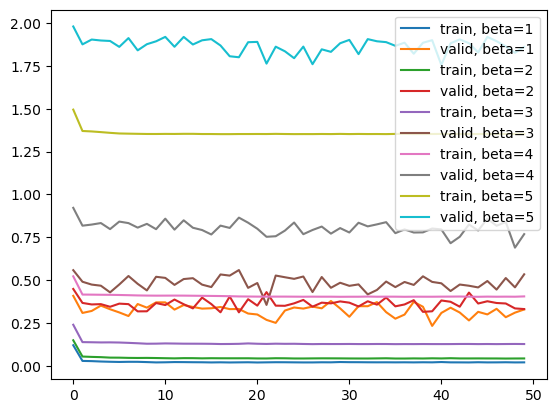

In [102]:
model = Autoencoder(n_users)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

train_losses = []
for beta in range(1, 6, 1):
    model = Autoencoder(n_users)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
    train_loss, valid_loss, best_weights = train_model(model, beta, criterion, optimizer, num_epochs=50)
    train_losses.append(train_loss)
    plt.plot(train_loss, label=f"train, beta={beta}")
    plt.plot(valid_loss, label=f"valid, beta={beta}")
    torch.save(best_weights, f'scale_b{beta}.pth')

plt.legend()
plt.show()

In [107]:
k=15
def compute_precision_recall_ndcg(preds, truths, k):
    batch_size, num_items = preds.shape
    _, indices = torch.topk(preds, k, dim=1)  # Get indices of top-k predictions
    relevant = torch.zeros_like(preds, dtype=torch.float).scatter_(1, indices, 1)  # Mark top-k predictions

    hits = (relevant * truths).sum(dim=1)  # Calculate hits by element-wise multiplication and summing over items
    precision = hits.sum().item() / (k * batch_size)  # Total hits / (k * number of users)
    recall = hits.sum().item() / truths.sum().item()  # Total hits / total true interactions

    # NDCG calculation
    ndcg = 0
    for i in range(batch_size):
        sorted_scores = preds[i, indices[i]]
        true_labels = truths[i, indices[i]]
        idcg = (1 / torch.log2(torch.arange(2, k+2).float())).sum()
        dcg = (true_labels / torch.log2(torch.arange(2, k+2).float())).sum()
        ndcg += (dcg / idcg)

    ndcg /= batch_size

    return precision, recall, ndcg

In [108]:
for beta in range(1, 6):
    print(f"Evaluating beta={beta}")
    state_dict = torch.load(os.getcwd() + f"/scale_b{beta}.pth")
    model = Autoencoder(n_users)
    model.load_state_dict(state_dict)
    test_loader = generate_dataloader(beta, "test")
    model.eval()
    for k in [15, 30]:
        precisions = []
        recalls = []
        ndcgs = []

        for inputs, targets in test_loader:
            reconstructed = model(inputs)
            precision, recall, ndcg = compute_precision_recall_ndcg(reconstructed, targets, k)
            precisions.append(precision)
            recalls.append(recall)
            ndcgs.append(ndcg)

        avg_precision = sum(precisions) / len(precisions)
        avg_recall = sum(recalls) / len(recalls)
        avg_ndcg = sum(ndcgs) / len(ndcgs)

        print(f'Average Precision@{k}: {avg_precision}')
        print(f'Average Recall@{k}: {avg_recall}')
        print(f'Average NDCG@{k}: {avg_ndcg}')

Evaluating beta=1
Average Precision@15: 0.14342881944444444
Average Recall@15: 0.03687472657087425
Average NDCG@15: 0.15524019300937653
Average Precision@30: 0.12626085069444443
Average Recall@30: 0.06121885244306635
Average NDCG@30: 0.13877122104167938
Evaluating beta=2
Average Precision@15: 0.14865885416666666
Average Recall@15: 0.038894308900606654
Average NDCG@15: 0.15995408594608307
Average Precision@30: 0.13239149305555556
Average Recall@30: 0.06598728092179015
Average NDCG@30: 0.14422692358493805
Evaluating beta=3
Average Precision@15: 0.14758680555555556
Average Recall@15: 0.04036980281667653
Average NDCG@15: 0.1588110774755478
Average Precision@30: 0.12927083333333336
Average Recall@30: 0.06479123934812715
Average NDCG@30: 0.14167313277721405
Evaluating beta=4
Average Precision@15: 0.14969184027777782
Average Recall@15: 0.0405151055940127
Average NDCG@15: 0.16183839738368988
Average Precision@30: 0.13267144097222222
Average Recall@30: 0.06712830991421877
Average NDCG@30: 0.145

In [110]:
def compute_metrics_and_mdg(preds, truths, k):
    batch_size, num_items = preds.shape
    _, indices = torch.topk(preds, k, dim=1)
    relevant = torch.zeros_like(preds, dtype=torch.float).scatter_(1, indices, 1)

    mdgs = []

    # Calculate MDG for each item
    for i in range(batch_size):
        user_mdgs = []
        for rank, index in enumerate(indices[i]):
            if truths[i, index] == 1:
                mdg = 1 / np.log2(1 + rank + 1)
                user_mdgs.append(mdg)
            else:
                user_mdgs.append(0)

        mdgs.append(np.mean(user_mdgs) if user_mdgs else 0)

    return np.mean(mdgs), mdgs

In [111]:
for beta in range(1, 6):
    print(f"Evaluating beta={beta}")
    state_dict = torch.load(os.getcwd() + f"/scale_b{beta}.pth")
    model = Autoencoder(n_users)
    model.load_state_dict(state_dict)
    test_loader = generate_dataloader(beta, "test")
    model.eval()

    mdg_values = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            reconstructed = model(inputs)
            avg_mdg, item_mdgs = compute_metrics_and_mdg(reconstructed, targets, k)
            mdg_values.extend(item_mdgs)

    # Calculate MDG-min10% and MDG-max10%
    mdg_values = np.array(mdg_values)
    print(f"mdg values top 10 {mdg_values}")
    nonzero_mdgs = np.count_nonzero(mdg_values)
    print(f"Number of non-zero MDG values: {nonzero_mdgs} out of {len(mdg_values)}")

    tenth_percentile_index = int(len(mdg_values) * 0.1)
    mdg_min10 = np.mean(np.sort(mdg_values)[:tenth_percentile_index])
    mdg_max10 = np.mean(np.sort(mdg_values)[-tenth_percentile_index:])

    print(f"MDG-min10%: {mdg_min10}")
    print(f"MDG-max10%: {mdg_max10}")

Evaluating beta=1
mdg values top 10 [0.         0.22373031 0.         ... 0.05087321 0.04042487 0.        ]
Number of non-zero MDG values: 901 out of 3018
MDG-min10%: 0.0
MDG-max10%: 0.23629022192529048
Evaluating beta=2
mdg values top 10 [0.         0.20831559 0.         ... 0.0494821  0.04384883 0.        ]
Number of non-zero MDG values: 903 out of 3018
MDG-min10%: 0.0
MDG-max10%: 0.23995975176403508
Evaluating beta=3
mdg values top 10 [0.         0.19180383 0.         ... 0.07285682 0.06029096 0.        ]
Number of non-zero MDG values: 902 out of 3018
MDG-min10%: 0.0
MDG-max10%: 0.23537712980377654
Evaluating beta=4
mdg values top 10 [0.         0.19614605 0.         ... 0.06717054 0.05297638 0.        ]
Number of non-zero MDG values: 904 out of 3018
MDG-min10%: 0.0
MDG-max10%: 0.2379924429848159
Evaluating beta=5
mdg values top 10 [0.         0.18468414 0.         ... 0.07108289 0.05162239 0.        ]
Number of non-zero MDG values: 903 out of 3018
MDG-min10%: 0.0
MDG-max10%: 0.2386

Evaluating beta=1


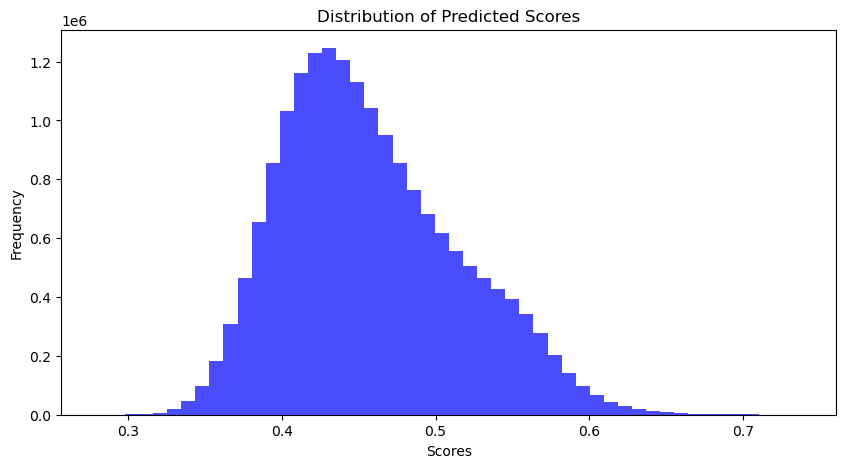

Evaluating beta=2


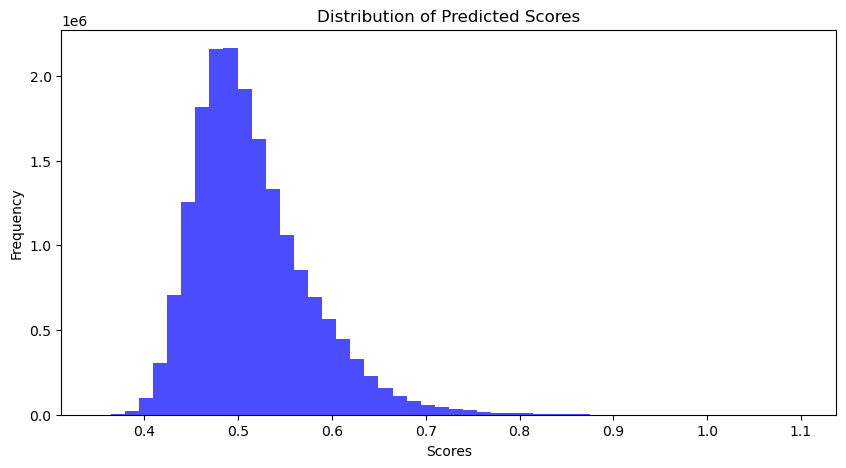

Evaluating beta=3


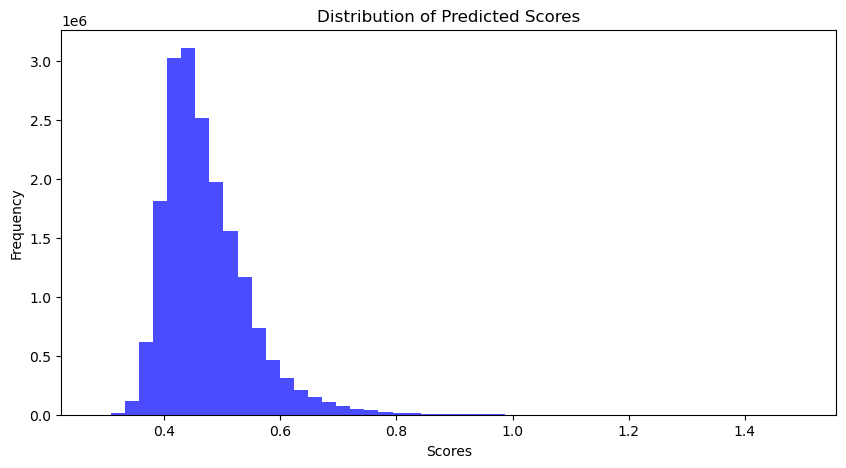

Evaluating beta=4


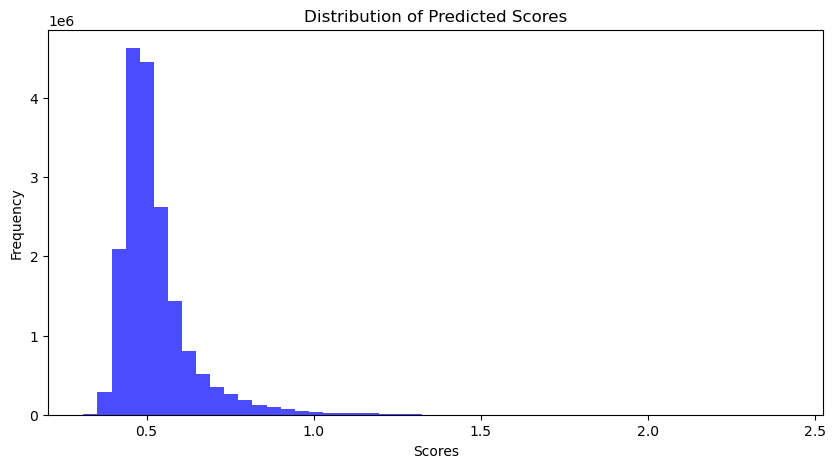

Evaluating beta=5


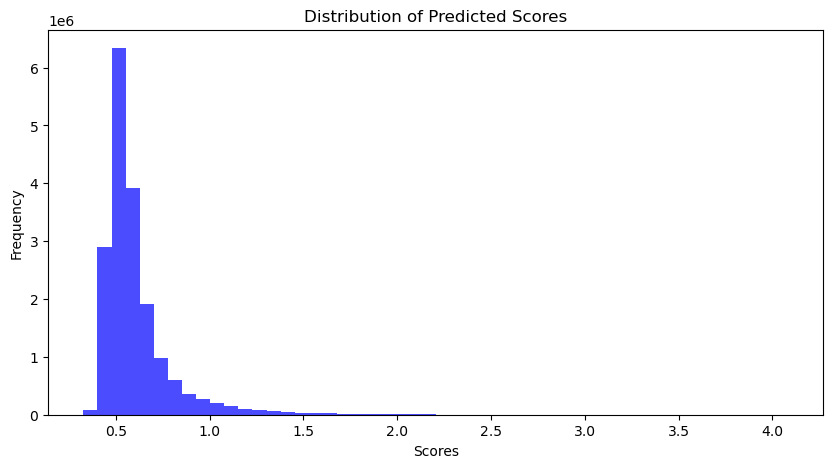

In [113]:
for beta in range(1, 6):
    print(f"Evaluating beta={beta}")
    state_dict = torch.load(os.getcwd() + f"/scale_b{beta}.pth")
    model = Autoencoder(n_users)
    model.load_state_dict(state_dict)
    test_loader = generate_dataloader(beta, "test")
    model.eval()

    scores = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            reconstructed = model(inputs)
            scores.extend(reconstructed.flatten().tolist())

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=50, color='blue', alpha=0.7)
    plt.title('Distribution of Predicted Scores')
    plt.xlabel('Scores')
    plt.ylabel('Frequency')
    plt.show()